<a href="https://colab.research.google.com/github/Nivratti/100-Days-Of-ML-Code/blob/master/StyleGAN2_Face_encoder_and_modificator_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+3">Face Encoder and Modificator with <font color="green" size="+3">Style<font color="red" size="+3">GAN<font color="green" size="+3">2</font></b>


**Modified**

https://github.com/Nivratti/stylegan2encoder


In [ ]:
#@title #**View GPU info** { display-mode: "form" }
!nvidia-smi

Tue Dec  8 15:56:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## <b><font color="red" size="+2" >Start</font></b>

In [1]:
#@title ### Install the required components { display-mode: "form" }
%%time
%tensorflow_version 1.x
# !pip install tensorflow-gpu==1.14  
# !pip install tensorflow-gpu==1.15.0 # linux 1.15 also works but not on windows

!pip install gdown
!pip install loguru

# !pip install gast==0.2.2  # older version -- to resolve module 'gast' has no attribute 'Num

TensorFlow 1.x selected.
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 102kB 5.7MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=d39b435fa228cef9aa46b7d27e54dff93bba026eae761bfd52ba08fe4b8606f3
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
CPU times: user 169 ms, sys: 36.6 ms, total: 205 ms
Wall time: 9.14 s


## Helper functions

In [2]:
#@title ### Google drive file downloader and string helper { display-mode: "form" }
from gdown import download
from loguru import logger

import string 
import random 


def download_drive_file(file_id, output):
    """
    Download file from google drive

    Args:
        file_id (str): google drive file-id to download
        output (str): path to write file

    Returns:
        Bool: Return True if successfull else False.
    """
    try:
        # download from google drive
        url = f'https://drive.google.com/uc?id={file_id}'
        logger.info("downloading file from google drive.")
        download(url, output, quiet=False)
        return True
    except Exception as e:
        logger.error(e)
        logger.error("Error while downloading file from google drive. Manually add model checkpoint.")
        return False


def generate_unique_str(allow_dashes=True):
    """
    Generate unique string using uuid package

    Args:
        allow_dashes (bool, optional): If true use uuid4() otherwise use hex that will skip dash in names. Defaults to True.
    """
    import uuid

    if allow_dashes:
        unique_str = str(uuid.uuid4())
    else:
        unique_str = uuid.uuid4().hex
    return unique_str


def generate_random_str(length=5):
    """
    generating random strings
    """
    # using random.choices() 
    # generating random strings  
    res = ''.join(
        random.choices(
            string.ascii_uppercase + string.digits,
            k = length
        )
    ) 
    # print("The generated random string : " + str(res)) 
    return res

## Clone encoder and face modification repository

In [3]:
%cd "/content"

/content


In [4]:
#@title ### Clone repository { display-mode: "form" }
!git clone https://github.com/Nivratti/stylegan2encoder

Cloning into 'stylegan2encoder'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 308 (delta 5), reused 9 (delta 3), pack-reused 294
Receiving objects: 100% (308/308), 8.99 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [5]:
#@title ### Move inside repository { display-mode: "form" }
%cd "/content/stylegan2encoder"

/content/stylegan2encoder


## Download or upload video

In [ ]:
# !wget "https://static.videezy.com/system/protected/files/000/042/936/VDO2019HD_0217.mov" -O "Woman Wearing White Shirt Waving Goodbye.mp4"

## Global variables

In [6]:
#@title ### Uploaded video processing base dir { display-mode: "form" }

import os
from loguru import logger


base_video_dir = "/content/stylegan2encoder/media/videos/"

# input_video_filepath = "/content/cap_pexels-close-up-footage-of-an-elderly-woman.mp4"

# # input_video_filepath = '/content/stylegan2encoder/Woman-Wearing-White-Shirt-Waving-Goodbye.mp4' #@param {type:"string"}

# # if input_video_filepath == "":
# #     logger.info("Error.. input video path cant be empty string..")
# #     logger.info("Please enter input video path")

# # if not os.path.exists(input_video_filepath):
# #     logger.info("Error.. input video file not exists..")
# #     logger.info("Please enter corrent input path or check permissions")
  
# # get-the-filename-without-the-extension-from-a-path
# video_filename = os.path.basename(input_video_filepath)
# file_head, ext = os.path.splitext(video_filename)
# # print(file_head)

#@markdown **Video folder name to store generated faces and stylegan data:**
video_filename="Woman-Wearing-White-Shirt-Waving-Goodbye.mp4" #@param {type:"string"}

# # folder for uploaded video processing
file_head, ext = os.path.splitext(video_filename)
video_processing_dir = os.path.join(base_video_dir, file_head)

if os.path.exists(video_processing_dir):
    random_str = generate_random_str(length=5)
    video_processing_dir = os.path.join(base_video_dir, file_head + "_" + random_str)
    logger.info(f"video_processing_dir already exists... creating new one")
    logger.info(f"new video_processing_dir: {video_processing_dir}")
else:
    logger.info(f"video_processing_dir: {video_processing_dir}")

os.makedirs(video_processing_dir, exist_ok=True)
# generate_random_str(length=5)
# input_video_base_dir 

2020-12-09 16:55:33.664 | INFO     | __main__:<module>:39 - video_processing_dir: /content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye


## Upload single photo 

Ideal : best straight looking neutral emotion face image

Other faces that will increase deepfacelab face swapping:
1.   Full visible faces
2.   all extreme emotions photos of videos


TODO: add video uploader and best key faces(straigh looking, neutral face, big smiling, visible full teeths, multiangle, multi expressions etc.) finder code later

Saving cap_data_dst_00_00_10_12.jpg to cap_data_dst_00_00_10_12.jpg
User uploaded file "cap_data_dst_00_00_10_12.jpg" with length 199936 bytes


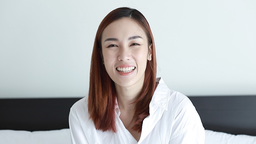

In [75]:
#@title #**Upload a photo with a face** { display-mode: "form" }
from google.colab import files


uploaded = files.upload()
for fp in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))

# move file inside 
import shutil

dir_straight_looking_face = os.path.join(video_processing_dir, "straigh_looking_facephoto")
os.makedirs(dir_straight_looking_face, exist_ok=True)
shutil.move(fp, dir_straight_looking_face)

straight_looking_facefile = os.path.join(dir_straight_looking_face, fp)

from PIL import Image
img1 = Image.open(straight_looking_facefile)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), Image.LANCZOS)
display(img1)

## Extract and align face

TODO: handle multiple faces

In [76]:
#@title ### Detect and get aligned faces { display-mode: "form" }
from face_extraction_alignment import single_image_extract_align_face
aligned_faces = single_image_extract_align_face(straight_looking_facefile)

# print(f"detected and aligned faces count: {len(aligned_faces)}")
# display(Image.fromarray(aligned_faces[1]).resize((512, 512))

if aligned_faces:
    pil_alignedface = Image.fromarray(aligned_faces[0])
    aligned_face_dir = os.path.join(video_processing_dir, 'aligned')
    os.makedirs(aligned_face_dir, exist_ok=True)
    aligned_face_path = os.path.join(aligned_face_dir, 'face.png')
    pil_alignedface.save(aligned_face_path)
else:
    logger.error("aligned_faces is empty cannot proceed fruther ...")

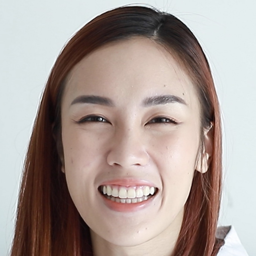

In [77]:
#@title ### Display first aligned face { display-mode: "form" }
display(Image.open(aligned_face_path).resize((256, 256)))

## Project_images.py

In [42]:
#@title ### Load packages { display-mode: "form" }
import argparse
import os
import shutil
import numpy as np

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
import projector
import dataset_tool
from training import dataset
from training import misc

from loguru import logger

In [43]:
#@title ### function to render video of projection { display-mode: "form" }
def render_video(src_file, dst_dir, tmp_dir, num_frames, mode, size, fps, codec, bitrate):

    import PIL.Image
    import moviepy.editor

    def render_frame(t):
        frame = np.clip(np.ceil(t * fps), 1, num_frames)
        image = PIL.Image.open('%s/video/%08d.png' % (tmp_dir, frame))
        if mode == 1:
            canvas = image
        else:
            canvas = PIL.Image.new('RGB', (2 * src_size, src_size))
            canvas.paste(src_image, (0, 0))
            canvas.paste(image, (src_size, 0))
        if size != src_size:
            canvas = canvas.resize((mode * size, size), PIL.Image.LANCZOS)
        return np.array(canvas)

    src_image = PIL.Image.open(src_file)
    src_size = src_image.size[1]
    duration = num_frames / fps
    filename = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.mp4')
    video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
    video_clip.write_videofile(filename, fps=fps, codec=codec, bitrate=bitrate)


In [44]:
# @title ### main function to project image { display-mode: "form" }
def project_image(base_dir, proj, src_file, video=False):
    projector_dir = os.path.join(base_dir, "projector")
    tmp_dir = os.path.join(projector_dir, ".stylegan2-tmp")
    os.makedirs(tmp_dir, exist_ok=True)
    data_dir = '%s/dataset' % tmp_dir
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)

    image_dir = '%s/images' % data_dir
    tfrecord_dir = '%s/tfrecords' % data_dir
    os.makedirs(image_dir, exist_ok=True)

    shutil.copy(src_file, image_dir + '/')
    dataset_tool.create_from_images(tfrecord_dir, image_dir, shuffle=0)
    dataset_obj = dataset.load_dataset(
        data_dir=data_dir, tfrecord_dir='tfrecords',
        max_label_size=0, repeat=False, shuffle_mb=0
    )

    logger.info('Projecting image "%s"...' % os.path.basename(src_file))
    images, _labels = dataset_obj.get_minibatch_np(1)
    images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.start(images)
    if video:
        video_dir = '%s/video' % tmp_dir
        os.makedirs(video_dir, exist_ok=True)
    while proj.get_cur_step() < proj.num_steps:
        print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
        proj.step()
        if video:
            filename = '%s/%08d.png' % (video_dir, proj.get_cur_step())
            misc.save_image_grid(proj.get_images(), filename, drange=[-1,1])
    print('\r%-30s\r' % '', end='', flush=True)

    dst_dir = os.path.join(projector_dir, "generated_images")
    os.makedirs(dst_dir, exist_ok=True)
    generated_image_file = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.png')
    misc.save_image_grid(proj.get_images(), generated_image_file, drange=[-1,1])
    
    latent_dst_dir = os.path.join(projector_dir, "latent_representations")
    os.makedirs(latent_dst_dir, exist_ok=True)
    latent_file = os.path.join(latent_dst_dir, os.path.basename(src_file)[:-4] + '.npy')
    np.save(latent_file, proj.get_dlatents()[0])
    return (generated_image_file, latent_file)

In [45]:
# @title ### Helpers to display projected(encoded) image  { display-mode: "form" }

import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
    f, axarr = plt.subplots(1,2, figsize=(fs,fs))
    axarr[0].imshow(img1)
    axarr[0].title.set_text('Encoded img %d' %img_id)
    axarr[1].imshow(img2)
    axarr[1].title.set_text('Original img %d' %img_id)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()

def display_encoding_result(src_file, generated_image_file, res = 512):
    img1 = Image.open(generated_image_file).resize((res,res))
    img2 = Image.open(src_file).resize((res,res))
    plot_two_images(img1,img2, 1)

    print("")

## Encode Image (project real image into latent space)

In [14]:
#@title ### Loading generator network { display-mode: "form" }
%%time

network_pkl='gdrive:networks/stylegan2-ffhq-config-f.pkl'

logger.info('Loading networks from "%s"...' % network_pkl)

# tflib.init_tf()

generator_network, discriminator_network, Gs_network = pretrained_networks.load_networks(
    network_pkl
)


2020-12-09 16:56:32.355 | INFO     | __main__:<module>:4 - Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
CPU times: user 12.4 s, sys: 1.94 s, total: 14.3 s
Wall time: 1min 3s


In [15]:
#@title ### Setup projector { display-mode: "form" }
%%time

base_dir = video_processing_dir
src_file = aligned_face_path

vgg16_pkl = 'https://drive.google.com/uc?id=1I3TD65EaDRmN5_yRXj0l20JsJVees3Cq'

#@markdown **Set the number of iterations of network learning:**

#@markdown *Recommended: 700*
num_steps=1500 #@param {type:"slider", min:500, max:4000, step:10}

#@markdown **Set learning rate:**

#@markdown *Recommended: 0.1*
initial_learning_rate = 0.05 #@param {type:"slider", min:0.01, max:1, step:0.01}

initial_noise_factor=0.05
verbose=False
video=False
video_mode=1
video_size=1024
video_fps=25
video_codec='libx264'
video_bitrate='5M'

proj = projector.Projector(
    vgg16_pkl             = vgg16_pkl,
    num_steps             = num_steps,
    initial_learning_rate = initial_learning_rate,
    initial_noise_factor  = initial_noise_factor,
    verbose               = verbose
)
proj.set_network(Gs_network)

CPU times: user 16.1 s, sys: 733 ms, total: 16.8 s
Wall time: 21.2 s


In [78]:
#@title ### Encode image { display-mode: "form" }
%%time

generated_image_file, latent_file = project_image(base_dir, proj, src_file)


Loading images from "/content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye/projector/.stylegan2-tmp/dataset/images"
Creating dataset "/content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye/projector/.stylegan2-tmp/dataset/tfrecords"
Added 1 image.


2020-12-09 17:40:42.053 | INFO     | __main__:project_image:21 - Projecting image "face.png"...


CPU times: user 3min 8s, sys: 1min 26s, total: 4min 34s
Wall time: 4min 55s


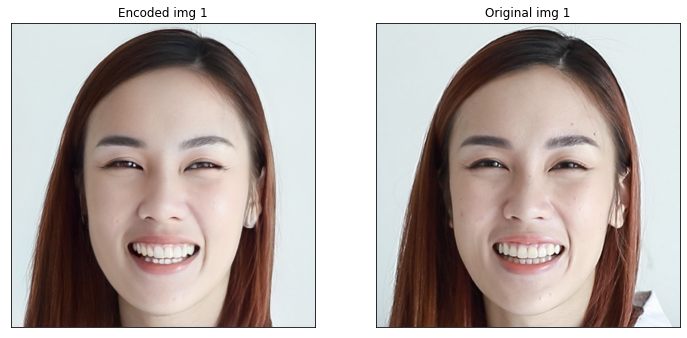

In [79]:
#@title ### Display encoded and original image { display-mode: "form" }
display_encoding_result(src_file, generated_image_file)

## Generator configuration for latent modification

In [80]:
#@title ### Configure the generator { display-mode: "form" }

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5


## <b><font color="red" size="+3" >Generate photos and animations</font></b>

In [81]:
#@title ### Latent modification utility { display-mode: "form" }

def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

def move_latent(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    # os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, Image.ANTIALIAS)
        # result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        
        # display(result.resize((512, 512)))

        if len(coeffs)==1:
          return result

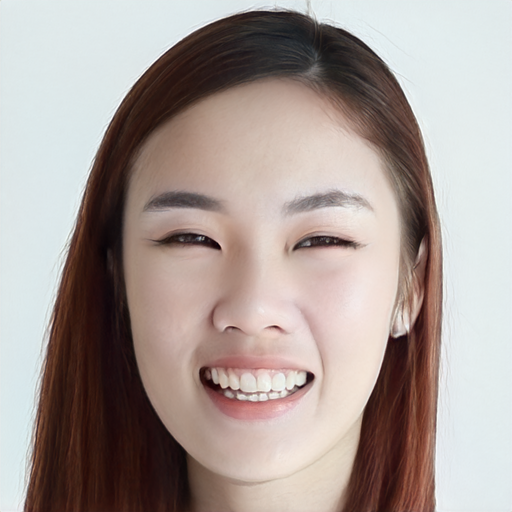

In [82]:
#@title #**Modify the face in photo** { run: "auto", display-mode: "form" }
v = np.load(latent_file)
v = np.array([v])

#@markdown **Choose what you would like to change.:**
parameter = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Parameter intensity:**
intensity = 12 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
boost_intensity = False #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 3
coeffs = [intensity]

# print(coeffs)

#@markdown **Image resolution:**
resolution = "512" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

modified_face_result = move_latent(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

display(modified_face_result.resize((512, 512)))

In [83]:
#@title #**Animating a face modification** { display-mode: "form" }

import imageio
import moviepy.editor as mpy

# v = np.load('latent_representations/'+fn[0])
v = np.load(latent_file)
v = np.array([v])

#@markdown **Choose what you would like to change.:**
parameter = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Starting intensity:**
start_intensity = 0 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Finishing intensity:**
finish_intensity = 12 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Number of frames:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:
  #@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
  boost_intensity = False #@param {type:"boolean"}
  if boost_intensity == True:
    start_intensity *= 3
    finish_intensity *= 3
  
  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)

  #@markdown **Animation Resolution:**
  resolution = "512" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

  #@markdown **Add video Invert:**

  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
      file_head, ext = os.path.splitext(i)
      if ext in [".png", ".jpg", ".jpeg"]:
          face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Starting intensity should be less than the finish!')

In [84]:
#@title #**Generate multiple frames by locking feature ** { display-mode: "form" }
from google.colab import files

v = np.load('latent_representations/'+fn[0])
v = np.array([v]) # если будет не похоже, то можно поэкспериментировать с (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **intensity:**
intensity = 0 #@param {type:"slider", min:-20, max:20, step:0.2}

#@markdown **Number of frames:**
frames = 21 #@param {type:"slider", min:10, max:100, step:1}

#@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
boost_intensity = False #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 3

# duration = abs(intensity)+abs(finish_intensity)
# steps = round(duration/frames,2)
coeffs = []

for i in range(1, frames):
  coeffs.append(intensity)

#@markdown **Animation Resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

#@markdown **Add video Invert:**

add_invert = True #@param {type:"boolean"}
face_img = []
img = os.listdir("results/"+direction_name)
img.sort()
for i in img:
  face_img.append(imageio.imread("results/" + direction_name + "/"+i))
if add_invert == True:
  for j in reversed(face_img):
    face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))

NameError: ignored


# <b><font color="red" size="+3" >Additional functions</font></b>

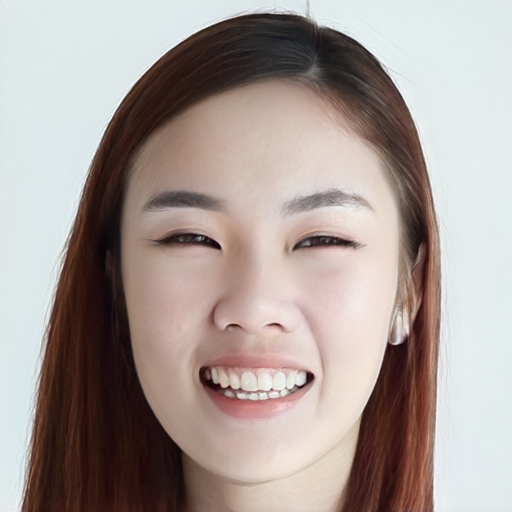

In [85]:
#@title #**Modify the face according to 3 parameters** { display-mode: "form" }
from google.colab import files

v = np.load(latent_file)
v = np.array([v])
!rm -rf results/3param

#@markdown **Choose the first option:**
parameter1 = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 12 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity1 = False #@param {type:"boolean"}

if boost_intensity1 == True:
    intensity1 *= 3

#@markdown **Choose the second option:**
parameter2 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 2.6 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity2 = False #@param {type:"boolean"}
if boost_intensity2 == True:
    intensity2 *= 3

#@markdown **Choose the third option:**
parameter3 = 'angle_vertical' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 3 #@param {type:"slider", min:-20, max:20, step:0.2}
boost_intensity3 = False #@param {type:"boolean"}
if boost_intensity3 == True:
    intensity3 *= 3

#@markdown **Image resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, Image.ANTIALIAS)
    result.save('results/3param/result_3param.png')
    return result

direction_intensity = (direction_file1*intensity1) + (direction_file2*intensity2) + (direction_file3*intensity3)
modified_face_result = move_latent_and_save_3_param(v, direction_intensity, Gs_network, Gs_syn_kwargs)

display(modified_face_result.resize((512, 512)))

In [86]:
#@title #**Animating face modification (3 parameters)** { display-mode: "form" }
import imageio
import moviepy.editor as mpy

# v = np.load('latent_representations/'+fn[0])
v = np.load(latent_file)
v = np.array([v])
!rm -rf results/3param

#@markdown **Number of frames:**
frames = 15 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **Choose the first option:**
parameter1 = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = 12 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity1 == 0: intensity1 += 0.001
boost_intensity1 = False #@param {type:"boolean"}
locked_feature1 = True #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3

coeffs1 = []
for i in range(0, frames):
  if locked_feature1:
    coeffs1.append(intensity1)
  else:
    coeffs1.append(round((i*intensity1)/frames,3))
    # print(round((i*intensity1)/frames,3))

#@markdown **Choose the second option:**
parameter2 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = -4 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity2 == 0: intensity2 += 0.001
boost_intensity2 = False #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

#@markdown **Choose the third option:**
parameter3 = 'angle_vertical' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 4.8 #@param {type:"slider", min:-20, max:20, step:0.2}
if intensity3 == 0: intensity3 += 0.001
boost_intensity3 = False #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

#@markdown **Animation Resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, frame_num, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, Image.ANTIALIAS)
    result.save('results/3param/result_(' + str(frame_num+1000) + ')_3param.png')
    return result

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  move_latent_and_save_3_param(v, direction_intensity, i, Gs_network, Gs_syn_kwargs)
  #clear_output()
  #print('Сгенерированно ' + str(i) + ' фото из ' + str(frames))

#@markdown **Add video Invert:**

add_invert = True #@param {type:"boolean"}
face_img = []
img = os.listdir("results/3param")
img.sort()
print('Animation is created. Please wait.')
for i in img:
  face_img.append(imageio.imread("results/3param/"+i))
if add_invert == True:
  for j in reversed(face_img):
    face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("results/3param/3param.mp4", face_img)
display(mpy.ipython_display("results/3param/3param.mp4", height=400, autoplay=1, loop=1))

Animation is created. Please wait.


In [ ]:
# !sudo rm -r "/content/stylegan2encoder/results/3param"

In [87]:
#@title ### function - move_latent_and_save_multi_param { display-mode: "form" }
def move_latent_and_save_multi_param(
    latent_vector, direction_intensity, frame_num, Gs_network, Gs_syn_kwargs, size=(512, 512),
    out_dir="results/3param", img_prefix="", img_name="result", img_postfix="", img_ext=".png",
    ):
    os.makedirs(out_dir, exist_ok=True)

    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, Image.ANTIALIAS)

    out_imgname = img_prefix +  img_name + "_" + str(frame_num) + img_postfix + img_ext
    # print(out_imgname)
    # result.save('results/3param/result_(' + str(frame_num+1000) + ')_3param.png')
    result.save(os.path.join(out_dir, out_imgname))
    return (result, out_imgname)

In [88]:
#@title ### function - generate_video_animation { display-mode: "form" }
import imageio
import moviepy.editor as mpy

def generate_video_animation(img_dir, lst_imgfile_names, out_video_dir="subdir", out_videofilename="3param.mp4", add_invert=True):
    # create video
    # add_invert = True
    face_img = []
    # lst_imgfiles = os.listdir("results/3param")
    # lst_imgfile_names.sort()
    print('Animation is created. Please wait.')
    
    for i in lst_imgfile_names:
        file_head, ext = os.path.splitext(i)
        if ext in [".png", ".jpg", ".jpeg"]:
            face_img.append(imageio.imread(os.path.join(img_dir, i) ))

    if add_invert == True:
        for j in reversed(face_img):
            face_img.append(j)

    face_img = np.array(face_img)

    if out_video_dir == "samedir":
        out_videofile = os.path.join(img_dir, out_videofilename)
    elif out_video_dir == "subdir":
        sub_dir = os.path.join(img_dir, "video")
        os.makedirs(sub_dir, exist_ok=True)
        out_videofile = os.path.join(sub_dir, out_videofilename)
    else:
        out_videofile = os.path.join(out_video_dir, out_videofilename)

    imageio.mimsave(out_videofile, face_img)
    return out_videofile


In [59]:
# !sudo rm -r "/content/stylegan2encoder/media/videos/single_human_face/frames"
# !sudo rm -r "/content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye/data_src"

## Generate de-aged faces of diffrent angles , emotions

In [54]:
#@title ### tasks(face manipulation) { display-mode: "form" }

## sample tasks code
tasks_sample = [
    {
    "number_of_frames": 12,
    "manipulation": [{
            "parameter"      : 'age',
            "intensity"      : -8.8,
            "boost_intensity": False,
            "locked_feature" : True,
        },
        {
            "parameter"      : 'angle_horizontal',
            "intensity"      : 19.8,
            "boost_intensity": False,
            "locked_feature" : False,
        },
        {
            "parameter"      : 'angle_vertical',
            "intensity"      : 20,
            "boost_intensity": False,
            "locked_feature" : False,
        }],
    },
]

############################
### actual tasks
############################

## face generation from too smiling face
# to generate faces for input face -- big smile and visible full upper and lower teeth
# this task will help deepfacelab model to render more clear teeth 
## Use below if
## Smiling face with visible upper side full teeth
tasks_big_smiling_face = [{
        "name"            : 'move face towards top-left corner',
        "number_of_frames": 15,
        "manipulation"    : [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 9,
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : 2.2,
                "boost_intensity": False,
                "locked_feature" : False,
            },
        ],
    },
    {
        "name"            : 'mouth closing -- closing full smiling(face with visible full upper teeth)',
        "number_of_frames": 15,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : +1.2,
            },
            {
                "parameter"      : 'smile',
                "intensity"      : 10,
            },
        ],
    },
]

## Use below if
## Neutral face
## straight looking face
## Open eyes
tasks_neutralface_straightlook_openeyes = [
    {
        "name"            : 'move face towards top-left corner',
        "number_of_frames": 15,
        "manipulation"    : [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 12,
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : 4,
                "boost_intensity": False,
                "locked_feature" : False,
            },
        ],
    },
    {
        "name"            : 'move face towards top-right corner',
        "number_of_frames": 15,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : -12,
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : 4,
            }
        ],
    },
    {
        "name"            : 'move face towards bottom-right corner',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 12,
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : -4,
            }
        ],
    },
    {
        "name"            : 'move face towards bottom-left corner',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : -12, # minus 
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : -4,   # vertical also minus
            }
        ],
    },
    {
        "name"            : 'move face towards right side with happy emotion',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 13,
            },
            {
                "parameter"      : 'emotion_happy',
                "intensity"      : 5,
            }
        ],
    },
    {
        "name"            : 'move face towards left side with happy emotion',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : -12,
            },
            {
                "parameter"      : 'emotion_happy',
                "intensity"      : 5,
            }
        ],
    },
    {
        "name"            : 'move face towards left side with anger emotion',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 12,
            },
            {
                "parameter"      : 'emotion_angry',
                "intensity"      : 5,
            }
        ],
    },
    {
        "name"            : 'move face towards left side with anger emotion',
        "number_of_frames": 5,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : -12,
            },
            {
                "parameter"      : 'emotion_angry',
                "intensity"      : 5,
            }
        ],
    },
    {
        "name"            : 'Smile',
        "number_of_frames": 10,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'smile',
                "intensity"      : -10,
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 4,
            },
        ],
    },
    {
        "name"            : 'close eyes',
        "number_of_frames": 20,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 4,
            },
            {
                "parameter"      : 'eyes_open',
                "intensity"      : 12,
            },
        ],
    },
    {
        "name"            : 'close eyes with smile',
        "number_of_frames": 15,
        "manipulation": [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'smile',
                "intensity"      : -10,
            },
            {
                "parameter"      : 'eyes_open',
                "intensity"      : 12,
            },
        ],
    },
]


## Use this 
# If you don't find any suitable tasks from above
# Usefull to generate faces for extreme face emotions
tasks_default = [{
        "name"            : 'move face towards top-left corner',
        "number_of_frames": 10, # or just 1
        "manipulation"    : [{
                "parameter"      : 'age',
                "_comment"       : 'use global values of intensity',
            },
            {
                "parameter"      : 'angle_horizontal',
                "intensity"      : 8.5,
            },
            {
                "parameter"      : 'angle_vertical',
                "intensity"      : 3,
                "boost_intensity": False,
                "locked_feature" : False,
            },
        ],
    },
]

In [33]:
#@title ### Multiple face generation method { display-mode: "form" }

def generated_manipulated_face_photos(latent_vector, tasks, dir_latent_directions, out_dir, Gs_network, Gs_syn_kwargs, global_fixed_feature_value={}, size=(512, 512), video=False, display_video=False):
    """
    Generate multiple photos by manipulating latent face

    manipulation factors:
      age, gface angle, emotions etc.
    """
    valid_latent_parameters = [
        "age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust",
        "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise",
        "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender",
        "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio",
        "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"
    ]
    total_generated_frames = 0

    for idx, task in enumerate(tasks, start=1):
        # print(idx)
        # print(task)
        number_of_frames = task.get("number_of_frames")
        # print(number_of_frames)

        total_generated_frames += number_of_frames

        manipulation = task.get("manipulation")
        # print(manipulation)

        lst_coeffs = []
        lst_direction_files = []
        out_img_name = ""

        for m in manipulation:
            parameter = m.get("parameter")
            intensity = m.get("intensity")
            boost_intensity = m.get("boost_intensity")
            locked_feature = m.get("locked_feature")

            print(parameter)

            if parameter not in valid_latent_parameters:
                logger.error(f"Invalid latent parameter '{parameter}'.")
                continue

            if intensity == 0:
                intensity += 0.001

            direction_file = np.load(
                os.path.join(
                    dir_latent_directions,
                    parameter + '.npy'
                )
            )
            lst_direction_files.append(direction_file)

            coeffs = []
            for i in range(0, number_of_frames):
                if parameter in global_fixed_feature_value:
                    intensity = global_fixed_feature_value.get(parameter)
                    coeffs.append(intensity)
                else:
                    if locked_feature:
                        coeffs.append(intensity)
                    else:
                        coeffs.append(
                            round((i * intensity) / number_of_frames, 3)
                        )
                        # print(round((i*intensity1)/number_of_frames,3))
            
            print(coeffs)
            lst_coeffs.append(coeffs)
            
            ## output image name generation
            if out_img_name:
                out_img_name += "__"
            out_img_name += parameter
            # add operator and value in str format 
            str_operator = "_plus" if intensity > 0 else  "_minus"
            out_img_name +=  str_operator + str(abs(intensity))

        print(f"Length of lst_coeffs: {len(lst_coeffs)}")
        print(f"Length of lst_direction_files: {len(lst_direction_files)}")
        # print(f"out_img_name: {out_img_name}")
        
        lst_imgfile_names = []
        for i in range(0, number_of_frames):
            direction_intensity = 0.001
            for c, coeffs in enumerate(lst_coeffs):
                direction_intensity += lst_direction_files[c] * coeffs[i]
        
            _r, out_imgname = move_latent_and_save_multi_param(
                latent_vector, direction_intensity, i, Gs_network, Gs_syn_kwargs,
                size, out_dir=out_dir, img_name=out_img_name,
            )
            lst_imgfile_names.append(out_imgname)
            # print(f"out_imgname: {out_imgname}")

        if video:
            img_dir = out_dir
            out_videofilename = out_imgname + ".mp4"
            out_videofile = generate_video_animation(
                img_dir, lst_imgfile_names,
                out_videofilename=out_videofilename
            )

        # display
        if display_video:
            display(mpy.ipython_display(out_videofile, height=400, autoplay=1, loop=1))

    return total_generated_frames

In [89]:
v = np.load(latent_file)
latent_vector = np.array([v])

dir_latent_directions = "latent_directions"
# out_dir = "results/3param"
out_dir = os.path.join(video_processing_dir, *["data_src", "frames"]) # younger /older face photo frames

#@markdown **Global Age:**
age = 12 #@param {type:"slider", min:-20, max:20, step:0.2}

# if global feature values passed the intensity given in taks list will be skipped
global_fixed_feature_value = {
    "age": age,
}

#@markdown **Input face category:**
task_name = 'tasks_default' #@param ["tasks_neutralface_straightlook_openeyes", "tasks_big_smiling_face", "tasks_sample", "tasks_default"]

# assign extact variable to perform face generation tasks
if task_name == "tasks_neutralface_straightlook_openeyes":
  tasks = tasks_neutralface_straightlook_openeyes
elif task_name == "tasks_big_smiling_face":
  tasks = tasks_big_smiling_face
elif task_name == "tasks_sample":
  tasks = tasks_sample
else:
  tasks = tasks_default

#@markdown **Synthesized face Resolution:**
resolution = "1024" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

total_generated_frames = generated_manipulated_face_photos(
    latent_vector, tasks, dir_latent_directions, out_dir,
    Gs_network, Gs_syn_kwargs,
    global_fixed_feature_value, size,
    video=False, display_video=False
)

print(f"\n\n total_generated_frames: {total_generated_frames} \n")

age
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
angle_horizontal
[0.0, 0.85, 1.7, 2.55, 3.4, 4.25, 5.1, 5.95, 6.8, 7.65]
angle_vertical
[0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7]
Length of lst_coeffs: 3
Length of lst_direction_files: 3


 total_generated_frames: 10 



In [74]:
!sudo rm -r "/content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye/data_src"

## Export data to google drive

In [35]:
#@title ### Connect to drive { display-mode: "form" }

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
# zip folder
# !zip -r 'single_human_face.zip' 'single_human_face'

# temp move inside folder
%cd "/content/stylegan2encoder/media/videos"

!zip -r 'Woman-Wearing-White-Shirt-Waving-Goodbye--just_morph.zip' 'Woman-Wearing-White-Shirt-Waving-Goodbye'
# move back to original folder
%cd "/content/stylegan2encoder"

/content/stylegan2encoder/media/videos
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/ (stored 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/.ipynb_checkpoints/ (stored 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/aligned/ (stored 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/aligned/face.png (deflated 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/ (stored 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/frames/ (stored 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/frames/age_plus12__angle_horizontal_plus8.5__angle_vertical_plus3_8.png (deflated 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/frames/age_plus12__angle_horizontal_plus8.5__angle_vertical_plus3_7.png (deflated 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/frames/age_plus12__angle_horizontal_plus8.5__angle_vertical_plus3_0.png (deflated 0%)
  adding: Woman-Wearing-White-Shirt-Waving-Goodbye/data_src/frames/ag

copy to drive

In [91]:
!cp '/content/stylegan2encoder/media/videos/Woman-Wearing-White-Shirt-Waving-Goodbye--just_morph.zip' '/content/drive/MyDrive/deepfake_data/synthesized_faces/Woman-Wearing-White-Shirt-Waving-Goodbye--just_morph.zip'